# FX Hedge Cost 10y

Diego Alvarez <br> diego.alvarez@colorado.edu

# Packages

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path Management

In [9]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")

hc_path = os.path.join(data_path, "hc.parquet")
eur_path = os.path.join(data_path, "eur_yield.parquet")
jpy_path = os.path.join(data_path, "jpy_yield.parquet")
ust_path = os.path.join(data_path, "tsy_yield.parquet")

# Read in Data

In [29]:
df_eur = (pd.read_parquet(
    path = eur_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "EUR"))

df_jpy = (pd.read_parquet(
    path = jpy_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-3:-1]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "JPY"))

df_us = (pd.read_parquet(
    path = ust_path, engine = "pyarrow").
    assign(ten_year = lambda x: x.security.str.split(" ").str[0].str[-4:-2]).
    query("ten_year == '10'").
    drop(columns = ["security", "ten_year"]).
    assign(country = "USA"))

df_yield = pd.concat([df_eur, df_jpy, df_us])

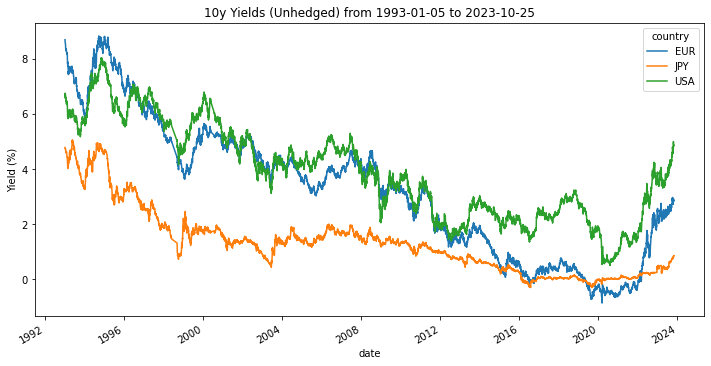

In [40]:
df_plot = (df_yield.pivot(
    index = "date", columns = "country", values = "PX_LAST").
    dropna())

(df_plot.plot(
    figsize = (12,6),
    ylabel = "Yield (%)",
    title = "10y Yields (Unhedged) from {} to {}".format(
        df_plot.index.min().date(),
        df_plot.index.max().date())))

plt.show()

In [50]:
df_hc = (pd.read_parquet(
    path = hc_path, engine = "pyarrow").
    assign(
        security = lambda x: x.security.str.split(" ").str[0],
        country = lambda x: np.where(x.security.str[-3] == "J", "JPY", "EUR")))

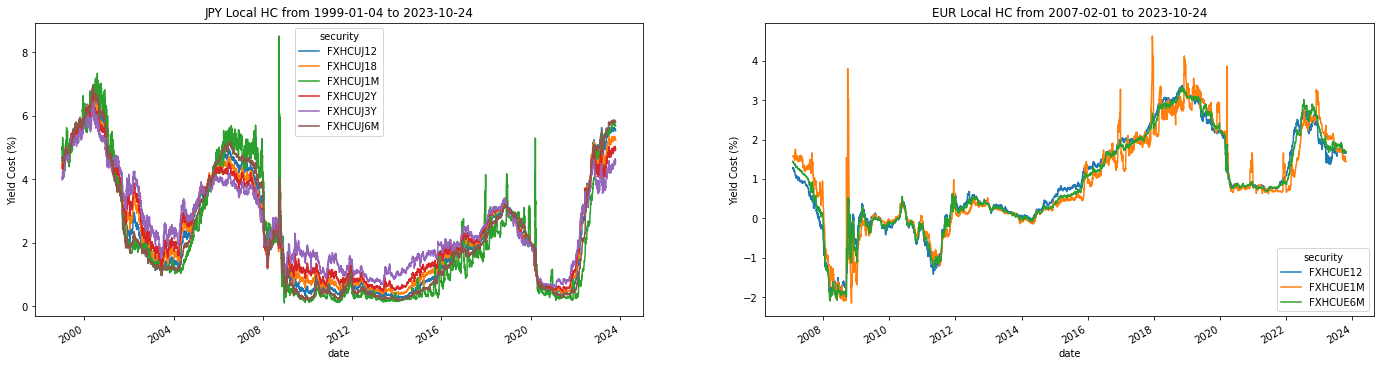

In [53]:
countries = df_hc.country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, figsize = (24,6))

for i, country in enumerate(countries):
    
    df_plot = (df_hc.query(
        "country == @country").
        drop(columns = ["country"]).
        pivot(index = "date", columns = "security", values = "PX_LAST").
        dropna())
    
    (df_plot.plot(
        ax = axes[i],
        ylabel = "Yield Cost (%)",
        title = "{} Local HC from {} to {}".format(
            country,
            df_plot.index.min().date(),
            df_plot.index.max().date())))

# Examining Sample Hedging Costs

In [66]:
df_us = (df_yield.query(
    "country == 'USA'").
    drop(columns = ["country"]).
    rename(columns = {"PX_LAST": "us_yield"}))

df_combined = (df_hc.merge(
    right = df_us, how = "inner", on = "date").
    assign(hedged_rate = lambda x: x.us_yield - x.PX_LAST).
    rename(columns = {"PX_LAST": "hedge_cost"}).
    merge(right = df_yield, how = "inner", on = ["date", "country"]).
    rename(columns = {"PX_LAST": "local_yield"}))

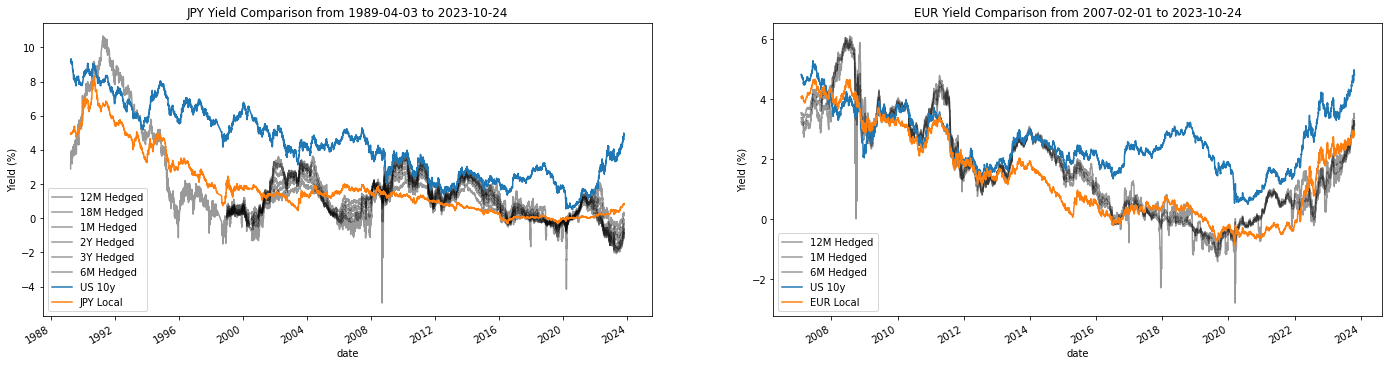

In [114]:
countries = df_combined.country.drop_duplicates().to_list()
fig, axes = plt.subplots(ncols = 2, figsize = (24,6))

for i, country in enumerate(countries):
    
    df_tmp = df_combined.query("country == @country")
    df_yield_tmp = (df_tmp[
        ["date", "us_yield", "local_yield"]].
        set_index("date").
        drop_duplicates().
        rename(columns = {
            "us_yield": "US 10y",
            "local_yield": "{} Local".format(country)}))
    
    (df_tmp[
        ["date", "security", "hedged_rate"]].
        assign(
            sec_tmp = lambda x: x.security.str[-2:],
            new_name = lambda x: np.where((x.sec_tmp.str[-1] != "M") & (x.sec_tmp.str[-1] != "Y"), x.sec_tmp + "M", x.sec_tmp),
            test = lambda x: x.new_name + " Hedged").
        drop(columns = ["security", "sec_tmp", "new_name"]).
        rename(columns = {"test": "tickers"}).
        pivot(index = "date", columns = "tickers", values = "hedged_rate").
        plot(
            ax = axes[i],
            color = "black",
            alpha = 0.4))
    
    (df_yield_tmp.plot(
        ax = axes[i],
        ylabel = "Yield (%)",
        title = "{} Yield Comparison from {} to {}".format(
            country,
            df_yield_tmp.index.min().date(),
            df_yield_tmp.index.max().date())))

    axes[i].legend(loc = "lower left")